# Random Walk

- There are instances where the simplest (naive forecasting) methods will yield the best forecasts in compared with sophisticated methods such as statistical or deep learning models. This is the case when we face a **random walk** process.
- A random walk is a sequence where the **first difference** is **not autocorrelated** and is a **stationary** process, meaning that its mean, variance, and autocorrelation are constant over time.
    - Because a random process takes random steps into the future, we **cannot use statistical or deep learning** techniques to fit such a process: there is **nothing to learn from randomness** and it cannot be predicted. Instead, we must **rely on naive forecasting methods**.
- If the process is not a random walk, so it can be approximated by the moving average (MA) model, an autoregressive (AR) model, or the combination of both processes, leading to an autoregressive moving average (ARMA) model.

## What is Random Walk Process
- A random walk is a process in which there is an equal chance of going up or down by a random number.
- Mathematically express a random walk with the following equation:
    - $y_t$ the value at the present time t
    - $C$ is a constant
    - $y_{t-1}$ is the value at the previous timestep t–1
    - $\epsilon_t$ is a random number (**white-noise**), which is the realization of the standard normal distribution, which has a variance of 1 and a mean of 0

$$ y_t = C + y_{t-1} + \epsilon_t$$

### Simulating a random walk process
By initializing our random walk process at 0 (i.e: $y_{t=0}=0$) and setting the constant $C$ to 0, we determine that the value at time $t$ is simply the sum of white noise from $t=1$ to time $t$, i.e. $y_t = \sum_{t=1}^T{\epsilon_t}$

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
import numpy as np
import plotly.express as px
np.random.seed(42)

steps = np.random.standard_normal(1000)
steps[0]=0 # set y_0 = 0
 
random_walk = np.cumsum(steps)

def plot_timeseries(ts:np.ndarray, 
                    title:str,
                    x = None,
                    ylabel: str = "value",
                    xlabel: str = "timesteps"):
    fig = px.line(x=range(0, len(ts)) if x is None else x, y=ts)
    fig.update_layout(
        title=title,
        yaxis_title=ylabel,
        xaxis_title=xlabel
    )
    fig.show()

plot_timeseries(random_walk, "Random Walk Simulation")

## Identifying a Random Walk
- A random walk is the series which is **stationary** (ADF test) and **un-correlated** (ACF plot) after a first-order differencing
- Step 1: test for stationarity (ADF, KPSS test). 
    - If it is not stationary, we apply transformations (differencing or log) until stationarity is achieved. 
- Step 2: Then we can plot the autocorrelation function (ACF).
    - If there is no autocorrelation, we have a random walk.

<p align="center"><img src="../assets/img/random-walk-identification-framework.png" height=500></p>

### Stationary

- A stationary time series is one whose statistical properties do not change over time
    - Namely: constant mean, variance, and autocorrelation, and these properties are independent of time.
- Intuitively, this makes sense, because if the data is non-stationary, its properties are going to change over time, which would mean that our model parameters must also change through time. 

In [6]:
from statsmodels.tsa.stattools import adfuller, kpss

def check_stationarity(series, p_significant=0.05):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [10]:
check_stationarity(random_walk)

ADF Statistic : -0.96595, p-value: 0.76548
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
KPSS Statistic: 1.11846, p-value: 0.01000
Non-stationary


- ADF statistic of –0.97 and a p-value of 0.77. 
- The ADF statistic is not a large negative number, and with a p-value greater than 0.05, we cannot reject the null hypothesis stating that our time series is not stationary.


### Autocorrelation Function
- Once a process is stationary, plotting the autocorrelation function (ACF) is a great way to understand what type of process you are analyzing. 
    - In this case, we will use it to determine if we are studying a random walk or not.
- The autocorrelation function (ACF) measures the linear relationship between lagged values of a time series.
    - In other words, it measures the correlation of the time series with itself.
    - The autocorrelation coefficient between $y_t$ and its lag=0 or $y_{t-0}=y_t$ is always $1$
    - The autocorrelation coefficient between $y_t$ and its lag=1 or $y_{t-1}$ is $r_1$
    - The autocorrelation coefficient between $y_t$ and its lag=2 or $y_{t-2}$ is $r_2$
- Understanding the ACF plot:
    - In the presence of a trend, a plot of the ACF will show that the coefficients are high for short lags, and they will decrease linearly as the lag increases.
    - In the presence of a seasonal, the ACF plot will also display cyclical patterns. 



In [19]:
# Because our random walk is not stationary, we need to apply a transformation to make it stationary in order to retrieve useful information from the ACF plot.
diff_random_walk = np.diff(random_walk, n=1)
# we have removed the trend from our series.
plot_timeseries(diff_random_walk, "Random Walk Simulation (diff=1)")

In [20]:
check_stationarity(diff_random_walk)

ADF Statistic : -31.78931, p-value: 0.00000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
KPSS Statistic: 0.19237, p-value: 0.10000
Stationary


In [50]:
def mean_over_time(process: np.array) -> np.array:
    mean_func = []
    
    for i in range(len(process)):
        mean_func.append(np.mean(process[:i]))
    
    return mean_func

non_stationary_mean = mean_over_time(random_walk)
stationary_mean = mean_over_time(diff_random_walk)

In [52]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=[i for i in range(0, len(stationary_mean))], y=stationary_mean, name='stationary',
                         line = dict(color='royalblue')))
fig.add_trace(go.Scatter(x=[i for i in range(0, len(non_stationary_mean))], y=non_stationary_mean, name='non-stationary',
                         line = dict(color='orange', dash='dash')))
fig.show()

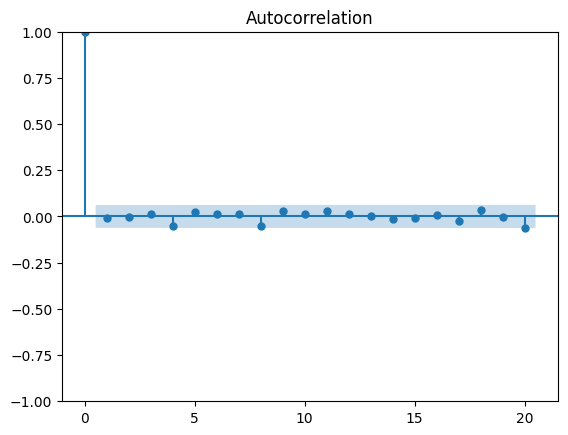

In [21]:
from statsmodels.graphics.tsaplots import plot_acf
 
plot_acf(diff_random_walk, lags=20); 

- The shaded area represents a confidence interval. 
    - If a point is within the shaded area, then it is not significantly
    - Otherwise, the autocorrelation coefficient is significant.
- From the above plot, there are no significant coefficients after lag 0. This is a clear indicator that we are dealing with a random walk

- Conclusion: our simulated data is indeed a random walk 
    - The series is **stationary** (ADF test) and **un-correlated** (ACF plot) after a first-order differencing, which corresponds to the definition of a random walk.

## Example of Random Walk Identification
- Example: Use daily closing price of GOOGL over 1 year to forecast the future closing price of the stock.
- To determine if the daily closing price of GOOGL can be modeled using the random walk model:
    - *Step 1*: determine whether our process is `stationary` or not. 
        - If it is a non-stationary process, we will have to apply transformations, such as `differencing`, in order to make it stationary. 
    - *Step 2*: Then we will be able to use the `autocorrelation` function plot to conclude that the daily closing price of GOOGL can be approximated by the random walk model. 

In [32]:
import pandas as pd
df = pd.read_csv("../data/book-time-series-forecasting-in-python/GOOGL.csv", parse_dates=[0])
plot_timeseries(df['Close'].values, 
                x=df['Date'].values,
                title="Closing price of GOOGL from April 27, 2020, to April 27, 2021",
                ylabel="Closing price (USD)",
                xlabel="Date")

In [33]:
check_stationarity(df["Close"])

ADF Statistic : 0.16025, p-value: 0.96994
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
KPSS Statistic: 2.18507, p-value: 0.01000
Non-stationary


- This returns an ADF statistic of 0.16 and a p-value greater than 0.05, so we know that our data is not stationary. 

In [35]:
diff_close = np.diff(df['Close'], n=1)
check_stationarity(diff_close)

ADF Statistic : -5.30344, p-value: 0.00001
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
KPSS Statistic: 0.08363, p-value: 0.10000
Stationary


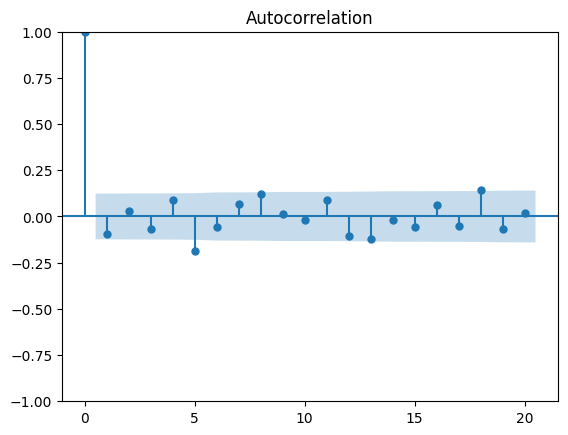

In [36]:
plot_acf(diff_close, lags=20);

- We do not see any significant coefficients, except at lags 5 and 18.
- This situation can arise sometimes, and it is due to chance only. In such a situation, we can safely assume that the coefficients at lags 5 and 18 are not significant, because we do not have consecutive significant coefficients.

## Forecasting a Random Walk
- Depending on the use case, your forecasting horizon will vary.
- Dealing with a random walk, you will only forecast the next timestep. 
- However, you may be required to forecast many timesteps into the future.

In [37]:
df = pd.DataFrame({'value': random_walk})   
 
train = df[:800]                            
test = df[800:]                              

### Forecasting on a long horizon
- This is not an ideal case — a random walk can unexpectedly increase or decrease because past observations are not predictive of changes in the future.
- Naive forecasting methods for this situation: 
    - Historical mean
    - Last known value
    - Drift method:   a modification of predicting the last known value. 
        - In this case, we allow the values to increase or decrease over time. 
        - The rate at which values will change in the future is equal to that seen in the train set. 
        - Therefore, it is equivalent to calculating the slope between the first and last value of the train set and simply extrapolating this straight line into the future.
            - $y_f$ the last value in the training set
            - $y_i$ the initial value in the training set
        $$\text{slope (drift)}= \frac{\Delta y}{\Delta x} = \frac {y_f - y_i}{\text{number of timesteps} - 1}$$
        $$forecast = slope * timestep + y_i$$
- Conclusion: forecasting a random walk on a long horizon does not make sense. Since the future value is dependent on the past value plus a random number.

In [53]:
# historical mean
hist_mean = np.mean(train.value)       
test.loc[:, 'pred_mean'] = hist_mean
# last value
last_value = train.iloc[-1].value       
test.loc[:, 'pred_last'] = last_value # Assign the last value as a prediction for the next 200 timesteps under the pred_last column.   

In [72]:
# drift 
drift = round((train.iloc[-1].value - train.iloc[1].value) / (train.shape[0] - 1), 4)
drift

-0.0084

- A drift of –0.0084, which means that the values of our forecasts will slowly decrease over time. 
- The drift method simply states that the value of our forecast is linearly dependent on the timestep

In [76]:
x_vals = np.arange(800, 1000, 1)        
 
pred_drift = drift * x_vals + train.iloc[1].value          
test.loc[:, 'pred_drift'] = pred_drift

In [88]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train['value'], name='train', line = dict(color='royalblue')))
fig.add_trace(go.Scatter(x=test.index, y=test['value'], name='test'))

for pred_type in ["pred_mean", "pred_last",	"pred_drift"]: 
    fig.add_trace(go.Scatter(x=test.index, y=test[pred_type], name=pred_type))
fig.show()

- Calculating the mean squared error (MSE) of our forecasts. We cannot use the MAPE, because our random walk can take the value 0—it is impossible to calculate the percentage difference from an observed value of 0 because that implies a division by 0

In [89]:
from sklearn.metrics import mean_squared_error
 
mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last'])
mse_drift = mean_squared_error(test['value'], test['pred_drift'])
 
print(mse_mean, mse_last, mse_drift)

326.50277395297474 425.1726033055617 466.5429997066388


- The best forecast was obtained by predicting the historical mean (`pred_mean`), and yet the MSE exceeds 300. This is an extremely high value considering that our simulated random walk does not exceed the value of 30.
- Conclusion: forecasting a random walk on a long horizon does not make sense. Since the future value is dependent on the past value plus a random number.

### Forecasting the next timestep
- We will make this forecast only for the next timestep.
- For example: the observed value at 8:00 a.m. is used to forecast the value for 9:00 a.m., the actual value observed at 9:00 a.m. is used to forecast the value at 10:00 a.m., and so on.
<p align="center"><img src="../assets/img/forecasting-next-timestep.png" width=600></p>



In [94]:
# For the sake of illustrating this method, we will apply it over the entire random walk.
# Forecast value at t will be the previous value at (t-1). This can be achieved by df.shift(1)
df_shift = df.shift(periods=1)


,value
0,NaN
1,0.000000
2,-0.138264
3,0.509424
4,2.032454


In [103]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['value'], name='actual', line = dict(color='royalblue')))
fig.add_trace(go.Scatter(x=df.index, y=df_shift['value'], name='forecast', line=dict(dash='dash')))
fig.show()

In [106]:
mean_squared_error(test["value"], df_shift["value"][800:])

0.9256876651440581

- This yields a value of 0.93, which again might lead us to think that we have a very performant model, since the MSE is very close to 0. 

- Because a random process takes random steps into the future, we cannot use statistical or deep learning techniques to fit such a process: there is nothing to learn from randomness and it cannot be predicted. Instead, we must rely on naive forecasting methods.

## Exercise
### Ex1: Simulate and forecast a random walk
- Simulate a different random walk than the one we have worked with in this chapter. You can simply change the seed and get new values:
- Generate a random walk of 500 timesteps. Feel free to choose an initial value different from 0. Also, make sure you change the seed by passing a different integer to `np.random.seed()`.
    - Plot your simulated random walk.
    - Test for stationarity.
    - Apply a first-order difference.
    - Test for stationarity & auto correlation: first-order difference series is stationary and un-correlated based on ACF
    - Split your simulated random walk into a train set containing the first 400 timesteps. The remaining 100 timesteps will be your test set.
    - Apply different naive forecasting methods and measure the MSE. Which method yields the lowest MSE?
    - Plot your forecasts.
    - Forecast the next timestep over the test set and measure the MSE. Did it decrease?

In [124]:
np.random.seed(40)
steps = np.random.standard_normal(500)
steps[0]=10 # set y_0 = 0
 
random_walk = np.cumsum(steps)

In [125]:
plot_timeseries(random_walk, title="Random Walk (500 steps)")

In [126]:
check_stationarity(random_walk)

ADF Statistic : -1.59134, p-value: 0.48794
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570
KPSS Statistic: 0.76522, p-value: 0.01000
Non-stationary


In [127]:
diff_random_walk = np.diff(random_walk, n=1)
check_stationarity(diff_random_walk)

ADF Statistic : -21.97353, p-value: 0.00000
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570
KPSS Statistic: 0.18112, p-value: 0.10000
Stationary


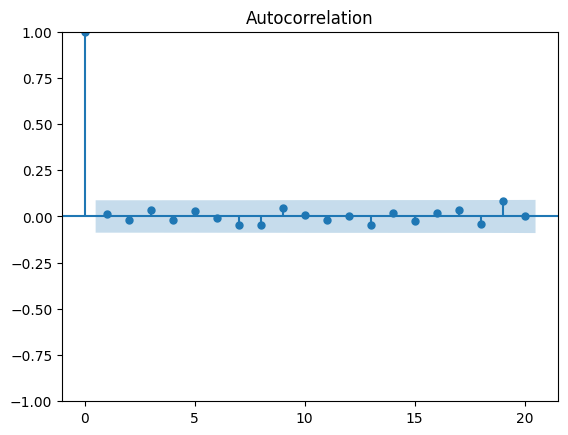

In [128]:
plot_acf(diff_random_walk, lags=20); # un-correlated

In [129]:
df = pd.DataFrame({'value': random_walk})   
 
train = df[:400]                            
test = df[400:] 

In [130]:
# historical mean
hist_mean = np.mean(train.value)       
test.loc[:, 'pred_mean'] = hist_mean
# last value
last_value = train.iloc[-1].value       
test.loc[:, 'pred_last'] = last_value # Assign the last value as a prediction for the next 200 timesteps under the pred_last column.  
# drift
drift = round((train.iloc[-1].value - train.iloc[1].value) / (train.shape[0] - 1), 4)
x_vals = np.arange(400, 500, 1)               
pred_drift = drift * x_vals + train.iloc[1].value          
test.loc[:, 'pred_drift'] = pred_drift

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last'])
mse_drift = mean_squared_error(test['value'], test['pred_drift'])
 
print(mse_mean, mse_last, mse_drift)

34.90129556985135 54.07514083616252 69.19946417759563


In [132]:
pred_drift = drift * x_vals + train.iloc[1].value          
test.loc[:, 'pred_drift'] = pred_drift

df_shift = df.shift(periods=1)
mse_one_step = mean_squared_error(test["value"], df_shift["value"][400:])
print(mse_one_step)

0.670898152293387
